# LASSO Feature Selection

# 1. Configuration & Data Loading

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso, LassoCV
from sklearn.feature_selection import mutual_info_classif

PROJECT_ROOT = Path("..").resolve()
IN_CSV = PROJECT_ROOT / "outputs" / "extracted_features.csv"

OUT_DIR = PROJECT_ROOT / "outputs"
RANK_DIR = OUT_DIR / "rankings"
DATASET_DIR = OUT_DIR / "datasets"
RANK_DIR.mkdir(parents=True, exist_ok=True)
DATASET_DIR.mkdir(parents=True, exist_ok=True)

FEATURE_COLS = ["CNT", "CRL", "SKEN", "KTS", "VAR", "STD", "ENT", "EG", "MN", "HGN", "RMS", "SM", "IDM"]

df = pd.read_csv(IN_CSV)
X = df[FEATURE_COLS].values
y = df["Output"].astype(int).values

print(f"Loaded {len(df)} samples with {len(FEATURE_COLS)} features from {IN_CSV}")

Loaded: E:\Kuliah\Pengenalan Pola\addressing_agricultural_challenges\outputs\extracted_features.csv
X: (724, 13) | y: (724,)


# 2. Scaling (MinMax for LASSO)

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print(f"Scaled features: min={X_scaled.min():.4f}, max={X_scaled.max():.4f}")

Scaled X: (724, 13) | min: 0.0 | max: 1.0000000000000018


# 3. LASSO Feature Selection

Best alpha (CV): 0.0001
Saved: E:\Kuliah\Pengenalan Pola\addressing_agricultural_challenges\outputs\rankings\lasso_rank.csv


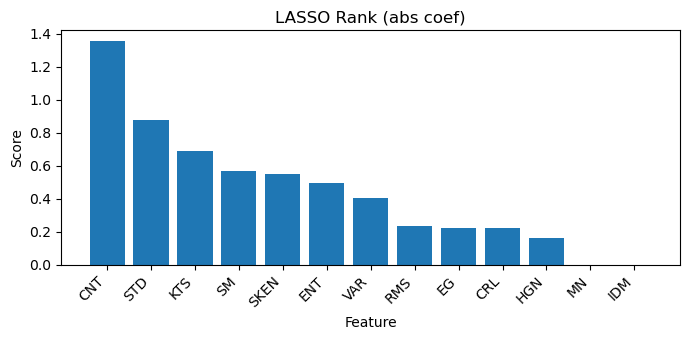

,feature,score
0,CNT,1.352424
1,STD,0.876128
2,KTS,0.688741
3,SM,0.566730
4,SKEN,0.547445
5,ENT,0.492333
6,VAR,0.402897
7,RMS,0.232559
8,EG,0.225123
9,CRL,0.219327


In [ ]:
alphas = np.logspace(-4, -1, 30)
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42, max_iter=20000)
lasso_cv.fit(X_scaled, y)
best_alpha = float(lasso_cv.alpha_)

print(f"Best alpha (5-fold CV): {best_alpha:.6f}")

lasso = Lasso(alpha=best_alpha, random_state=42, max_iter=20000)
lasso.fit(X_scaled, y)

coef = np.abs(lasso.coef_)
lasso_rank = (
    pd.DataFrame({"feature": FEATURE_COLS, "score": coef})
    .sort_values("score", ascending=False)
    .reset_index(drop=True)
)

lasso_rank_path = RANK_DIR / "lasso_rank.csv"
lasso_rank.to_csv(lasso_rank_path, index=False)
print(f"✓ LASSO ranking saved to {lasso_rank_path}")

fig, ax = plt.subplots(figsize=(7, 3.5))
ax.bar(lasso_rank["feature"], lasso_rank["score"])
ax.set_title("LASSO Feature Ranking (Absolute Coefficients)")
ax.set_xlabel("Feature")
ax.set_ylabel("Coefficient Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

lasso_rank

Saved: E:\Kuliah\Pengenalan Pola\addressing_agricultural_challenges\outputs\rankings\mutual_info_rank.csv


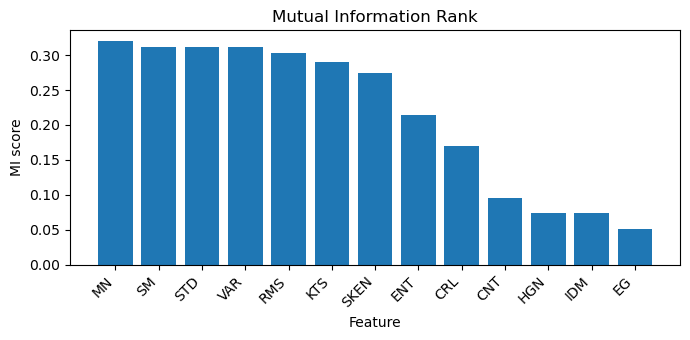

,feature,score
0,MN,0.319487
1,SM,0.311769
2,STD,0.311572
3,VAR,0.311572
4,RMS,0.302394
5,KTS,0.290726
6,SKEN,0.273838
7,ENT,0.214745
8,CRL,0.170082
9,CNT,0.095635


In [ ]:
mi = mutual_info_classif(X_scaled, y, random_state=42)

mi_rank = (
    pd.DataFrame({"feature": FEATURE_COLS, "score": mi})
    .sort_values("score", ascending=False)
    .reset_index(drop=True)
)

mi_rank_path = RANK_DIR / "mutual_info_rank.csv"
mi_rank.to_csv(mi_rank_path, index=False)
print(f"✓ Mutual information ranking saved to {mi_rank_path}")

fig, ax = plt.subplots(figsize=(7, 3.5))
ax.bar(mi_rank["feature"], mi_rank["score"])
ax.set_title("Mutual Information Feature Ranking")
ax.set_xlabel("Feature")
ax.set_ylabel("MI Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

mi_rank

# 4. Export Top-K Feature Datasets

In [ ]:
TOP_K_LIST = [5, 7, 9, 10]
METADATA_COLS = [c for c in ["ClassName", "orig_path", "prep_path"] if c in df.columns]

print(f"\nExporting top-K datasets:")
for k in TOP_K_LIST:
    top_feats = lasso_rank["feature"].head(k).tolist()
    out_cols = top_feats + ["Output"] + METADATA_COLS
    out_df = df[out_cols].copy()
    out_path = DATASET_DIR / f"data{k}L.csv"
    out_df.to_csv(out_path, index=False)
    print(f"  ✓ {out_path.name}: {out_df.shape}")

Saved: E:\Kuliah\Pengenalan Pola\addressing_agricultural_challenges\outputs\datasets\data5L.csv | cols: 9
Saved: E:\Kuliah\Pengenalan Pola\addressing_agricultural_challenges\outputs\datasets\data7L.csv | cols: 11
Saved: E:\Kuliah\Pengenalan Pola\addressing_agricultural_challenges\outputs\datasets\data9L.csv | cols: 13
Saved: E:\Kuliah\Pengenalan Pola\addressing_agricultural_challenges\outputs\datasets\data10L.csv | cols: 14
